<a href="https://colab.research.google.com/github/Pragu3704/brain_cancer_classifier/blob/main/brain_cancer_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Partial credit for code and model architecture - https://github.com/wisdomml2020/brain_tumour_classification/

# Mounting google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [4]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers
from tqdm import tqdm


# Viewing train dataset images

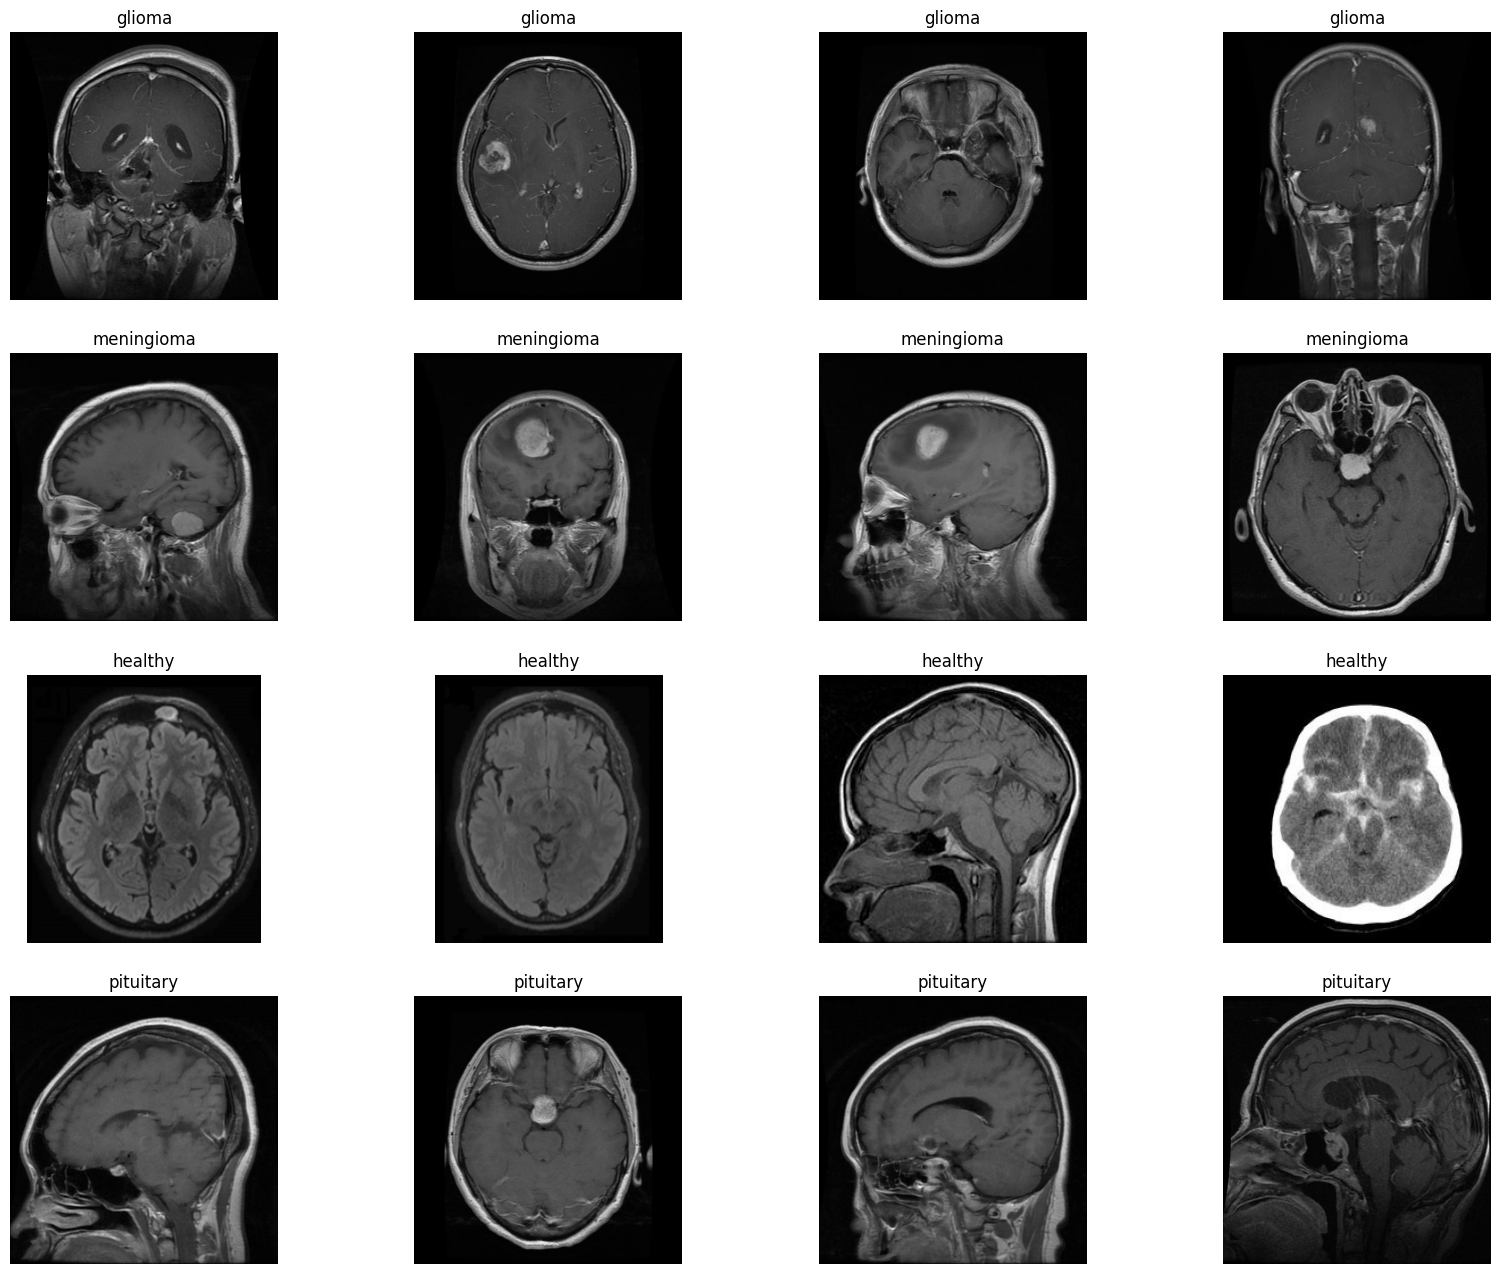

In [ ]:
train_image_path = '/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Training'
categories = ['glioma', 'meningioma', 'healthy', 'pituitary']

plt.figure(figsize=(20, 16))

for i, category in enumerate(categories):
    category_path = os.path.join(train_image_path, category)
    image_paths = os.listdir(category_path)
    for j, image_path in enumerate(image_paths[:4]):
        img = plt.imread(os.path.join(category_path, image_path))
        plt.subplot(4, 4, i*4+j+1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')

plt.show()

# Cropping images from both train and test set for easy training

In [ ]:
import cv2
import imutils
from concurrent.futures import ThreadPoolExecutor

IMG_SIZE = 256
INPUT_DIRS = {
    "Training": "/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Training/",
    "Testing": "/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Testing"
}
OUTPUT_DIRS = {
    "Training": "/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Training_crop",
    "Testing": "/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Testing_crop"
}

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if not cnts:
        return img  # Return original if no contours are found

    c = max(cnts, key=cv2.contourArea)
    extLeft, extRight = tuple(c[c[:, :, 0].argmin()][0]), tuple(c[c[:, :, 0].argmax()][0])
    extTop, extBot = tuple(c[c[:, :, 1].argmin()][0]), tuple(c[c[:, :, 1].argmax()][0])

    return img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()

def process_image(input_path, output_path):
    image = cv2.imread(input_path, cv2.IMREAD_COLOR)
    if image is None:
        return
    cropped = crop_img(image)
    resized = cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))
    cv2.imwrite(output_path, resized)

def process_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    tasks = []

    with ThreadPoolExecutor() as executor:
        for root, _, files in os.walk(input_folder):
            category = os.path.basename(root)
            save_path = os.path.join(output_folder, category)
            os.makedirs(save_path, exist_ok=True)

            for img_name in files:
                input_path = os.path.join(root, img_name)
                output_path = os.path.join(save_path, img_name)
                tasks.append(executor.submit(process_image, input_path, output_path))

if __name__ == "__main__":
    for key, input_dir in INPUT_DIRS.items():
        output_dir = OUTPUT_DIRS[key]
        process_folder(input_dir, output_dir)


In [ ]:
labels = ['glioma', 'meningioma', 'healthy', 'pituitary']
x_train, y_train = [], []
x_test, y_test = [], []
image_size = 100

for label in labels:
    trainPath = os.path.join('/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Training_crop', label)
    if not os.path.exists(trainPath):
        print(f"Warning: Training folder '{trainPath}' not found!")
        continue

    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file), 0)
        if image is None:
            print(f"Skipping unreadable image: {file}")
            continue
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join('/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Testing_crop', label)
    if not os.path.exists(testPath):
        print(f"Warning: Testing folder '{testPath}' not found!")
        continue

    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file), 0)
        if image is None:
            print(f"Skipping unreadable image: {file}")
            continue
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:00<00:00, 103.38it/s]


(2870, 100, 100, 3)
(394, 100, 100, 3)


# Visulaising cropped images

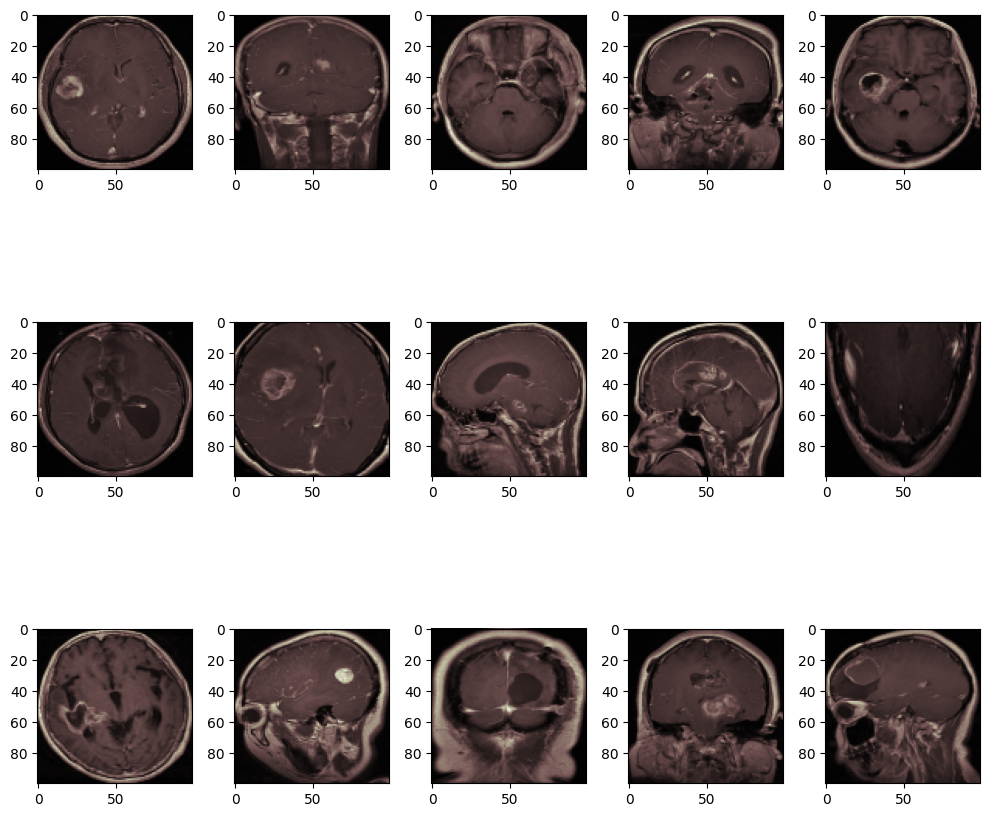

In [ ]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
x_train, y_train = shuffle(x_train,y_train, random_state=42)

y_train = tensorflow.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tensorflow.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(574, 100, 100, 3)


In [ ]:
datagen = ImageDataGenerator(
     rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# Fitting the data
datagen.fit(x_train)

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE=(100,100)
conv_base = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

In [ ]:
model = conv_base.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= conv_base.input, outputs= model)

#compiling model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)              ‚îÉ Output Shape           ‚îÉ        Param # ‚îÉ Connected to           ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_1             ‚îÇ (None, 100, 100, 3)    ‚îÇ              0 ‚îÇ -                      ‚îÇ
‚îÇ (InputLayer)              ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_pad (ZeroPadding2D) ‚îÇ (None, 106, 106, 3)    ‚îÇ              0 ‚îÇ input_layer_1[0][0]    ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_conv (Conv2D)       ‚îÇ (None, 50, 50, 64)     ‚îÇ          9,472 ‚îÇ conv1_pad[0][0]        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_bn                  ‚îÇ (None, 50, 50, 64)     ‚îÇ            256 ‚îÇ conv1_conv[0][0]       ‚îÇ
‚îÇ (BatchNormalization)      ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_relu (Activation)   ‚îÇ (None, 50, 50, 64)     ‚îÇ              0 ‚îÇ conv1_bn[0][0]         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ pool1_pad (ZeroPadding2D) ‚îÇ (None, 52, 52, 64)     ‚îÇ              0 ‚îÇ conv1_relu[0][0]       ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ pool1_pool (MaxPooling2D) ‚îÇ (None, 25, 25, 64)     ‚îÇ              0 ‚îÇ pool1_pad[0][0]        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2_block1_1_conv       ‚îÇ (None, 25, 25, 64)     ‚îÇ          4,160 ‚îÇ pool1_pool[0][0]       ‚îÇ
‚îÇ (Conv2D)                  ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Defining training parameters and training the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
callbacks = [ModelCheckpoint('.mdl_wts.keras', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]


train_len = len(x_train)
val_len = len(x_val)
print("Training Data length")
print(train_len)

print("Validation Data length")
print(val_len)

history = model.fit(datagen.flow(x_train, y_train, batch_size=32),validation_data = (x_val,y_val),epochs = 20,callbacks = callbacks)


Training Data length
2296
Validation Data length
574
Epoch 1/20
72/72 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6s/step - accuracy: 0.6983 - loss: 0.7277
Epoch 1: val_loss improved from inf to 4.81532, saving model to .mdl_wts.keras
72/72 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 503s 7s/step - accuracy: 0.6994 - loss: 0.7254 - val_accuracy: 0.2753 - val_loss: 4.8153 - learning_rate: 1.0000e-04
Epoch 2/20
72/72 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6s/step - accuracy: 0.8999 - loss: 0.2605
Epoch 2: val_loss improved from 4.81532 to 2.14916, saving model to .mdl_wts.keras
72/72 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 554s 7s/step - accuracy: 0.9000 - loss: 0.2604 - val_accuracy: 0.2596 - val_loss: 2.1492 - learning_rate: 1.0000e-04
Epoch 3/20
72/72 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6s/step - accuracy: 0.9518 - loss: 0.1583
Epoch 3: val_loss did not improve from 2.14916
7

# Plotting training and validation results

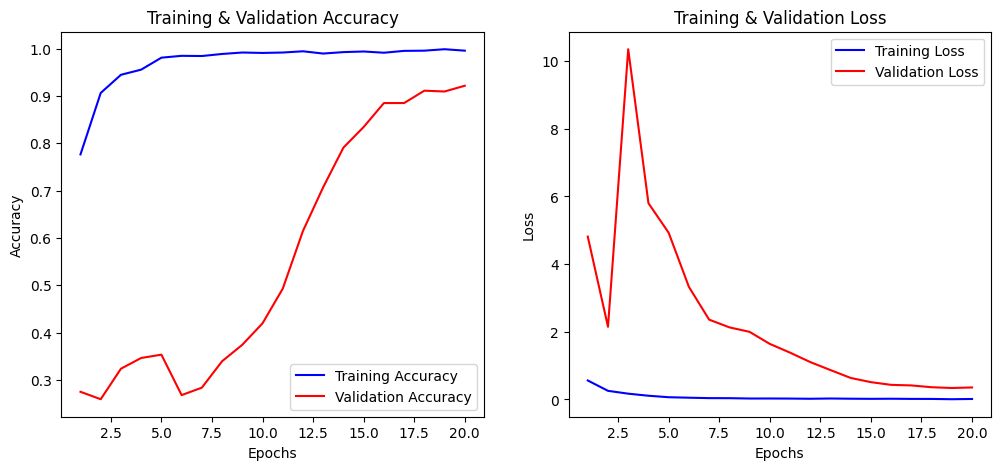

In [ ]:
def plot_training_history(history):
    # Extracting loss and accuracy from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call the function after training
plot_training_history(history)


# Saving the trained model

In [ ]:
model.save("/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/brain_tumor_model.keras")

# Visualising validation of model on images in Testing_crop

Found 394 images belonging to 4 classes.
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 1s/step - accuracy: 0.2752 - loss: 4.8223

üîπ Test Accuracy: 30.71%
üîπ Test Loss: 4.6296

üîπ Testing one image from each category:

‚úÖ True Label: Glioma
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step


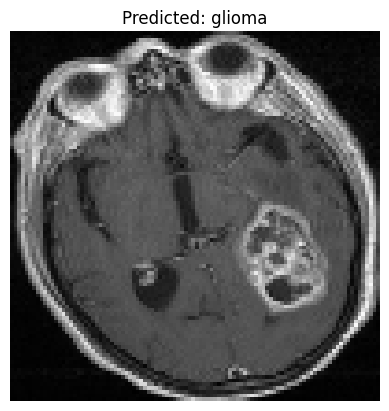

üîπ Predicted Label: Glioma
----------------------------------------
‚úÖ True Label: Healthy
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 81ms/step


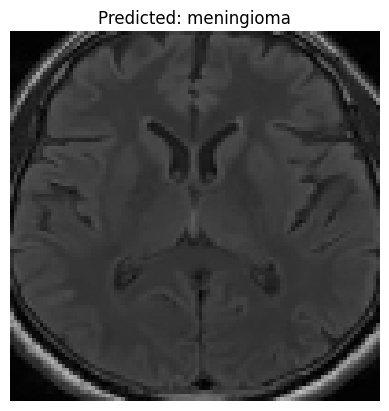

üîπ Predicted Label: Meningioma
----------------------------------------
‚úÖ True Label: Meningioma
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 80ms/step


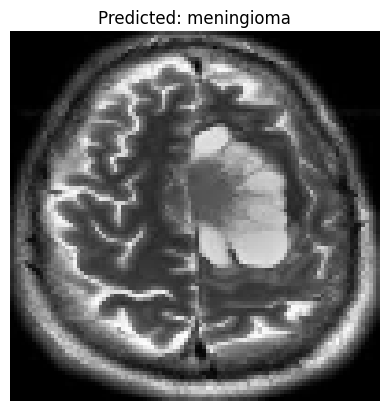

üîπ Predicted Label: Meningioma
----------------------------------------
‚úÖ True Label: Pituitary
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 79ms/step


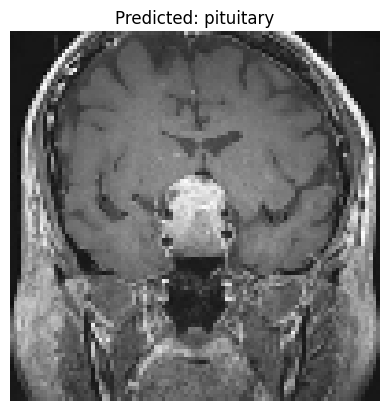

üîπ Predicted Label: Pituitary
----------------------------------------
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 1s/step

üîπ Classification Report:
              precision    recall  f1-score   support

      glioma       0.83      0.44      0.58       100
     healthy       0.02      0.02      0.02       105
  meningioma       0.08      0.10      0.09       115
   pituitary       0.72      0.85      0.78        74

    accuracy                           0.31       394
   macro avg       0.41      0.35      0.37       394
weighted avg       0.37      0.31      0.32       394



In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

#Loading trained model
model = load_model("/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/brain_tumor_model.keras")

img_size = (100, 100)  # Must match training image size

#Loading test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Testing_crop",
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

#Getting true labels and category names
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Evaluating model on the full test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nüîπ Test Accuracy: {test_accuracy*100:.2f}%")
print(f"üîπ Test Loss: {test_loss:.4f}\n")

#Function to predict a single image
def predict_single_image(img_path, model):
    if not os.path.exists(img_path):
        print(f"Error: Image not found at {img_path}")
        return "Image Not Found"

    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Failed to load image {img_path}")
        return "Invalid Image"

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color
    img = cv2.resize(img, (100, 100))  # Resize
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Display results
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.show()

    return class_names[predicted_class]

#Predicting one image from each tumor category
category_paths = {
    "glioma": "/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Testing_crop/glioma/image(98).jpg",
    "healthy": "/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Testing_crop/healthy/image(98).jpg",
    "meningioma": "/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Testing_crop/meningioma/image(98).jpg",
    "pituitary": "/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Testing_crop/pituitary/image(98).jpg"
}

print("üîπ Testing one image from each category:\n")
for true_label, img_path in category_paths.items():
    print(f"‚úÖ True Label: {true_label.capitalize()}")
    predicted = predict_single_image(img_path, model)
    print(f"üîπ Predicted Label: {predicted.capitalize()}")
    print("-" * 40)

#Generating classification report
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nüîπ Classification Report:")
print(classification_report(true_labels, y_pred_classes, target_names=class_names))


# Plotting confusion matrix

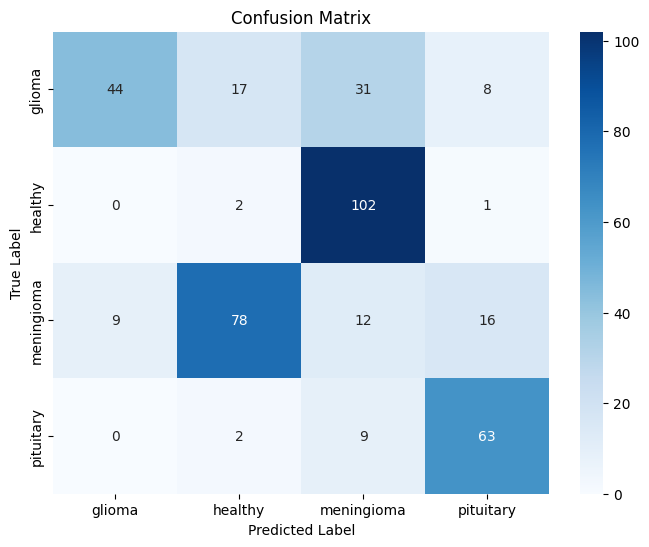

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Computing confusion matrix
cm = confusion_matrix(true_labels, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Saving csv file of true vs predicted values for test set

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import os


model = load_model("/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/brain_tumor_model.keras")


img_size = (100, 100)


test_dir = "/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/Testing_crop"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,  # Process one image at a time to get filenames
    class_mode='categorical',
    shuffle=False
)

# Get true labels & category names
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Predicting the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class index

# Create CSV file with Image ID, True Label, and Predicted Label
image_filenames = test_generator.filenames  # Get image filenames

# Convert file paths to only filenames
image_ids = [os.path.basename(f) for f in image_filenames]

# Create a DataFrame
df = pd.DataFrame({
    "Image ID": image_ids,
    "True Label": [class_names[i] for i in true_labels],  # Map indices to class names
    "Predicted Label": [class_names[i] for i in y_pred_classes]  # Predictions
})

# Save as CSV file
csv_filename = "/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/test_predictions.csv"
df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' generated successfully!")


Found 394 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


394/394 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 79ms/step
CSV file '/content/drive/My Drive/Kaggle/brain-tumor-classification-mri/test_predictions.csv' generated successfully!
